# Predikcia 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [2]:
pd.options.display.width = None
pd.options.display.max_columns = None

In [3]:
from Models import CombineDatasets as d1
from Models import DecodeJSONColumn as d2
from Models import ColumnDropper as d3
from Models import BinaryEncoder as d4
from Models import ClassFixer as d5
from Models import FixDates as d6
from Models import ComputeCurYear as d7
from Models import Replacer as d8
from Models import FillMeasuredColumns as d9
from Models import CountMeasuredHormones as d10
from Models import FillNanNumeric as d11
from Models import PredictNanNumeric as d12
from Models import Classifier as d13
from Models import QuantileReplacer as d14
from Models import Fitter as d15
from Models import ColumnSelector as d16

In [4]:
bool_columns = [
    'FTI measured',
    'I131 treatment',
    'T3 measured',
    'goitre',
    'lithium',
    'on thyroxine',
    'pregnant',
    'tumor',
    'query on thyroxine',
    'thyroid surgery',
    'TSH measured',
    'query hyperthyroid',
    'TT4 measured',
    'on antithyroid medication',
    'sick',
    'T4U measured',
    'psych',
    'query hypothyroid'
]

# Zadefinovanie pipelinov pomocou ktorych budeme spracovavat data

In [5]:
from sklearn.pipeline import FeatureUnion

In [153]:
# Transformacna pipelina, ktora robi transformacie nad zadanymi datasetmi
transf_ppl = Pipeline([
    ('combination', d1.CombineDatasets()),
    ('json_decode', d2.DecodeJSONColumn('medical_info')),
    ('drop_columns', d3.ColumnDropper(['hypopituitary', 'TBG measured', 'TBG'])),
    ('binary_fixer', d4.BinaryEncoder(bool_columns)),
    ('class_fix', d5.ClassFixer()),
    ('fix_dates', d6.FixDates()),
    ('compute_cur_year', d7.ComputeCurYear()),
    ('fti_question_mark_to_nan2', d8.Replacer(['FTI'], '?.4', float('nan'), str)),
    ('fti_question_mark_to_nan', d8.Replacer(['FTI'], '?', float('nan'), str)),
    ('fti_question_mark_to_nan1', d8.Replacer(['FTI'], np.nan, float('nan'), str)),
    ('fti_question_mark_to_nan3', d8.Replacer(['FTI'], np.nan, float('nan'), float)),
    ('fill_measured_columns', d9.FillMeasuredColumns()),
    ('count_measured', d10.CountMeasuredHormones('measured_hormones'))
])
    
# Pipelina ktora doplna chybajuce hodnoty
pred_ppl = Pipeline([
    # Fill hormony
    ('fitter', d15.Fitter()),
    ('fill_tt4', d11.FillNanNumeric('mean', 'TT4')),
    ('fill_tsh', d11.FillNanNumeric('median', 'TSH')),
    ('predicted_t3', d12.PredictNanNumeric('T3', ['TT4', 'TSH'])),
    ('predicted_t4u', d12.PredictNanNumeric('T4U', ['TT4', 'TSH'])),
    ('predicted_fti', d12.PredictNanNumeric('FTI', ['TT4', 'TSH', 'T4U'])),
    
    # Fill pregnant
    ('pregnant_predict', d13.Classifier('pregnant', ['T3', 'T4U', 'TT4'])),
    
    # Fill other variables
    ('fill_tumor', d11.FillNanNumeric('median', 'tumor')),
    ('fill_lithium', d11.FillNanNumeric('mean', 'lithium')),
    ('fill_on_thyroxine', d11.FillNanNumeric('mean', 'on thyroxine')),
    ('fill_goitre', d11.FillNanNumeric('most_frequent', 'goitre')),
    ('fill_q_on_thyroxine', d11.FillNanNumeric('mean', 'query on thyroxine')),
    
    #Replace outlier
    ('replace_t3', d14.QuantileReplacer('T3')),
    ('replace_age', d14.QuantileReplacer('age')),
    ('replace_t4u', d14.QuantileReplacer('T4U')),
    ('replace_tsh', d14.QuantileReplacer('TSH')),
    ('replace_tt4', d14.QuantileReplacer('TT4')),
    ('replace_fti', d14.QuantileReplacer('FTI')),
    ('column_selector', d16.ColumnSelector(['T3', 'T4U', 'TSH', 'TT4', 'measured_hormones', 'class']))
])

## Nacitanie trenovacich dat a ich spracovanie

In [154]:
data_personal_train = pd.read_csv("data/personal_train.csv")
data_other_train = pd.read_csv("data/other_train.csv")

In [155]:
data_train = transf_ppl.fit_transform(data_personal_train, data_other_train)
data_train = pred_ppl.fit_transform(data_train, data_train)

## Nacitanie validacnych dat a ich spracovanie

In [156]:
data_personal_valid = pd.read_csv("data/personal_valid.csv")
data_other_valid = pd.read_csv("data/other_valid.csv")

In [157]:
data_valid = transf_ppl.fit_transform(data_personal_train, data_other_train)

In [158]:
mdl_valid = pred_ppl.fit(data_valid)
data_valid = mdl_valid.transform(data_valid)

## Nacitanie testovacich dat a ich spracovanie

In [39]:
data_personal_test = pd.read_csv("data/personal_test.csv")
data_other_test = pd.read_csv("data/other_test.csv")

In [40]:
data_test = transf_ppl.fit_transform(data_personal_test, data_other_test)

In [41]:
mdl = pred_ppl.fit(data_test)
data_test = mdl.transform(data_test)

KeyError: "['class'] not in index"

----

## Rozhodovacie pravidlá

In [17]:
data_train.groupby('class').count()

Unnamed: 0_x  name  address   age   sex  \
class                                                                
decreased binding protein             9     9        9     9     9   
increased binding protein            97    97       97    97    97   
negative                           2131  2131     2131  2130  2131   

                           date_of_birth  FTI measured  I131 treatment    T3  \
class                                                                          
decreased binding protein              9             9               9     9   
increased binding protein             97            97              97    97   
negative                            2130          2131            2131  2131   

                           T3 measured   T4U   TSH   TT4  Unnamed: 0_y  \
class                                                                    
decreased binding protein            9     9     9     9             9   
increased binding protein           97    97    97    97            97   
negative                          2131  2131  2131  2131          2131   

                           capital-gain  capital-loss  education  \
class                                                              
decreased binding protein             9             9          9   
increased binding protein            97            97         97   
negative                           2131          2131       2131   

                           education-num  fnlwgt  goitre  hours-per-week  \
class                                                                      
decreased binding protein              7       9       9               9   
increased binding protein             91      97      97              97   
negative                            1915    2131    2131            2131   

                           lithium  marital-status  native-country  \
class                                                                
decreased binding protein        9               9               9   
increased binding protein       97              97              97   
negative                      2131            2131            2131   

                           occupation  on thyroxine  pregnant  \
class                                                           
decreased binding protein           9             9         9   
increased binding protein          97            97        97   
negative                         2131          2131      2131   

                           query on thyroxine  race  referral source  \
class                                                                  
decreased binding protein                   9     9                9   
increased binding protein                  97    97               97   
negative                                 2131  2131             2131   

                           relationship  thyroid surgery  tumor  workclass  \
class                                                                        
decreased binding protein             9                9      9          6   
increased binding protein            97               97     97         89   
negative                           2131             2131   2131       1975   

                           TSH measured  query hyperthyroid  TT4 measured  \
class                                                                       
decreased binding protein             9                   9             9   
increased binding protein            97                  97            97   
negative                           2131                2131          2131   

                           on antithyroid medication   FTI  sick  \
class                                                              
decreased binding protein                          9     9     9   
increased binding protein                         97    97    97   
negative                                        2131  2131  2131   

                          

In [18]:
data_train[data_train['class'] == 'increased binding protein']

Unnamed: 0_x                  name  \
21              21       Elizabeth Davis   
36              36       Judy Sprengeler   
69              69            Lorna Nery   
137            137            Vicki Barr   
161            161     Maricela Mcaninch   
169            169          Joyce Hubley   
179            179        Rose Broderick   
198            198  Christina Fitzgerald   
233            233          Sarah Travis   
236            236        Karla Campbell   
242            242      Eleanor Souliere   
251            251         Helen Scruggs   
256            256           Tina Sholar   
295            295      Catherine Gainer   
333            333      Cynthia Valencia   
393            393          Dawn Herrera   
411            411        Willie Stevens   
419            419          Maria Newman   
439            439         Marlene Smith   
455            455           Stacy White   
463            463      Phyliss Brummett   
465            465         Elvira Graham   
476            476        Laurie Auduong   
484            484       Sue Constantine   
542            542      Samantha Scavone   
574            574           Marlene Ray   
609            609      Elizabeth Bozell   
632            632         Regina Loftin   
644            644          Raquel Rooks   
658            658        Betty Donnelly   
...            ...                   ...   
1596          1596         Deidre Paxton   
1598          1598       Candice Conklin   
1605          1605       Jeannette Handy   
1629          1629        Sylvester Toon   
1643          1643         Shirley Kiser   
1645          1645          Hazel Oneill   
1773          1773            Lori Reaid   
1796          1796           Ethel Luthy   
1805          1805          Stacey Amaya   
1828          1828           Eric Garcia   
1837          1837        Lizabeth Black   
1838          1838       Tiffany Seawell   
1878          1878          Emily Ogburn   
1892          1892         Lorina Hoover   
1903          1903           Marta Scott   
1919          1919           Kathy Eason   
1942          1942         Sally Nettles   
1962          1962         Gregory Huynh   
1964          1964         Angela Thomas   
1984          1984          Walter Amado   
2031          2031     Elizabeth Frisbie   
2040          2040    Albert Picklesimer   
2052          2052          Traci Galvan   
2061          2061        Carrie Jackson   
2090          2090           Anne Lofton   
2157          2157           Jerry Hayes   
2184          2184           Sharon Paik   
2186          2186           Callie Ross   
2190          2190        Daniel Boswell   
2212          2212    Hayley Quintanilla   

                                                address   age sex  \
21    6934 Victor Turnpike Apt. 644\nLake Paulamouth...  71.0   F   
36            1487 Kirk Haven\nBrennanborough, MD 66214  20.0   F   
69    8983 Jacob Unions Suite 081\nCharlesville, MN ...  34.0   F   
137   54042 Richard Way Suite 787\nPort Edwin, MO 44530  31.0   F   
161   45891 David Haven Suite 448\nStaffordstad, WV ...  29.0   F   
169     386 Paula Street Apt. 754\nGardnerton, DE 85513  20.0   F   
179                    Unit 6320 Box 5535\nDPO AE 25156  47.0   F   
198   197 Ramirez Spring Suite 365\nWest Brandonview...  29.0   F   
233    8589 Richard Mount Apt. 190\nBrownstad, IA 31698  25.0   F   
236    545 Phillips Curve Apt. 514\nJulieland, HI 38630  32.0   F   
242      46965 Crystal Highway\nThomaschester, IN 73865  29.0   F   
251             4907 Fuller Estates\nHallview, ID 83315  20.0   F   
256     20519 Anderson Stravenue\nNew Michael, IL 88622  34.0   F   
295    946 Ponce Land Suite 823\nElliottmouth, AL 72414  36.0   F   
333    670 Arnold Lights Suite 837\nReneebury, AZ 84548  28.0   F   
393             937 Hart Mission\nSouth Amber, CT 18594  31.0   F   
411   687 Danielle Vista Suite 229\nSouth Amyburgh, ...  32.0   F   
419   6807 Sexton Valleys Apt. 075\

/Users/edvin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/edvin/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/edvin/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/edvin/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/U

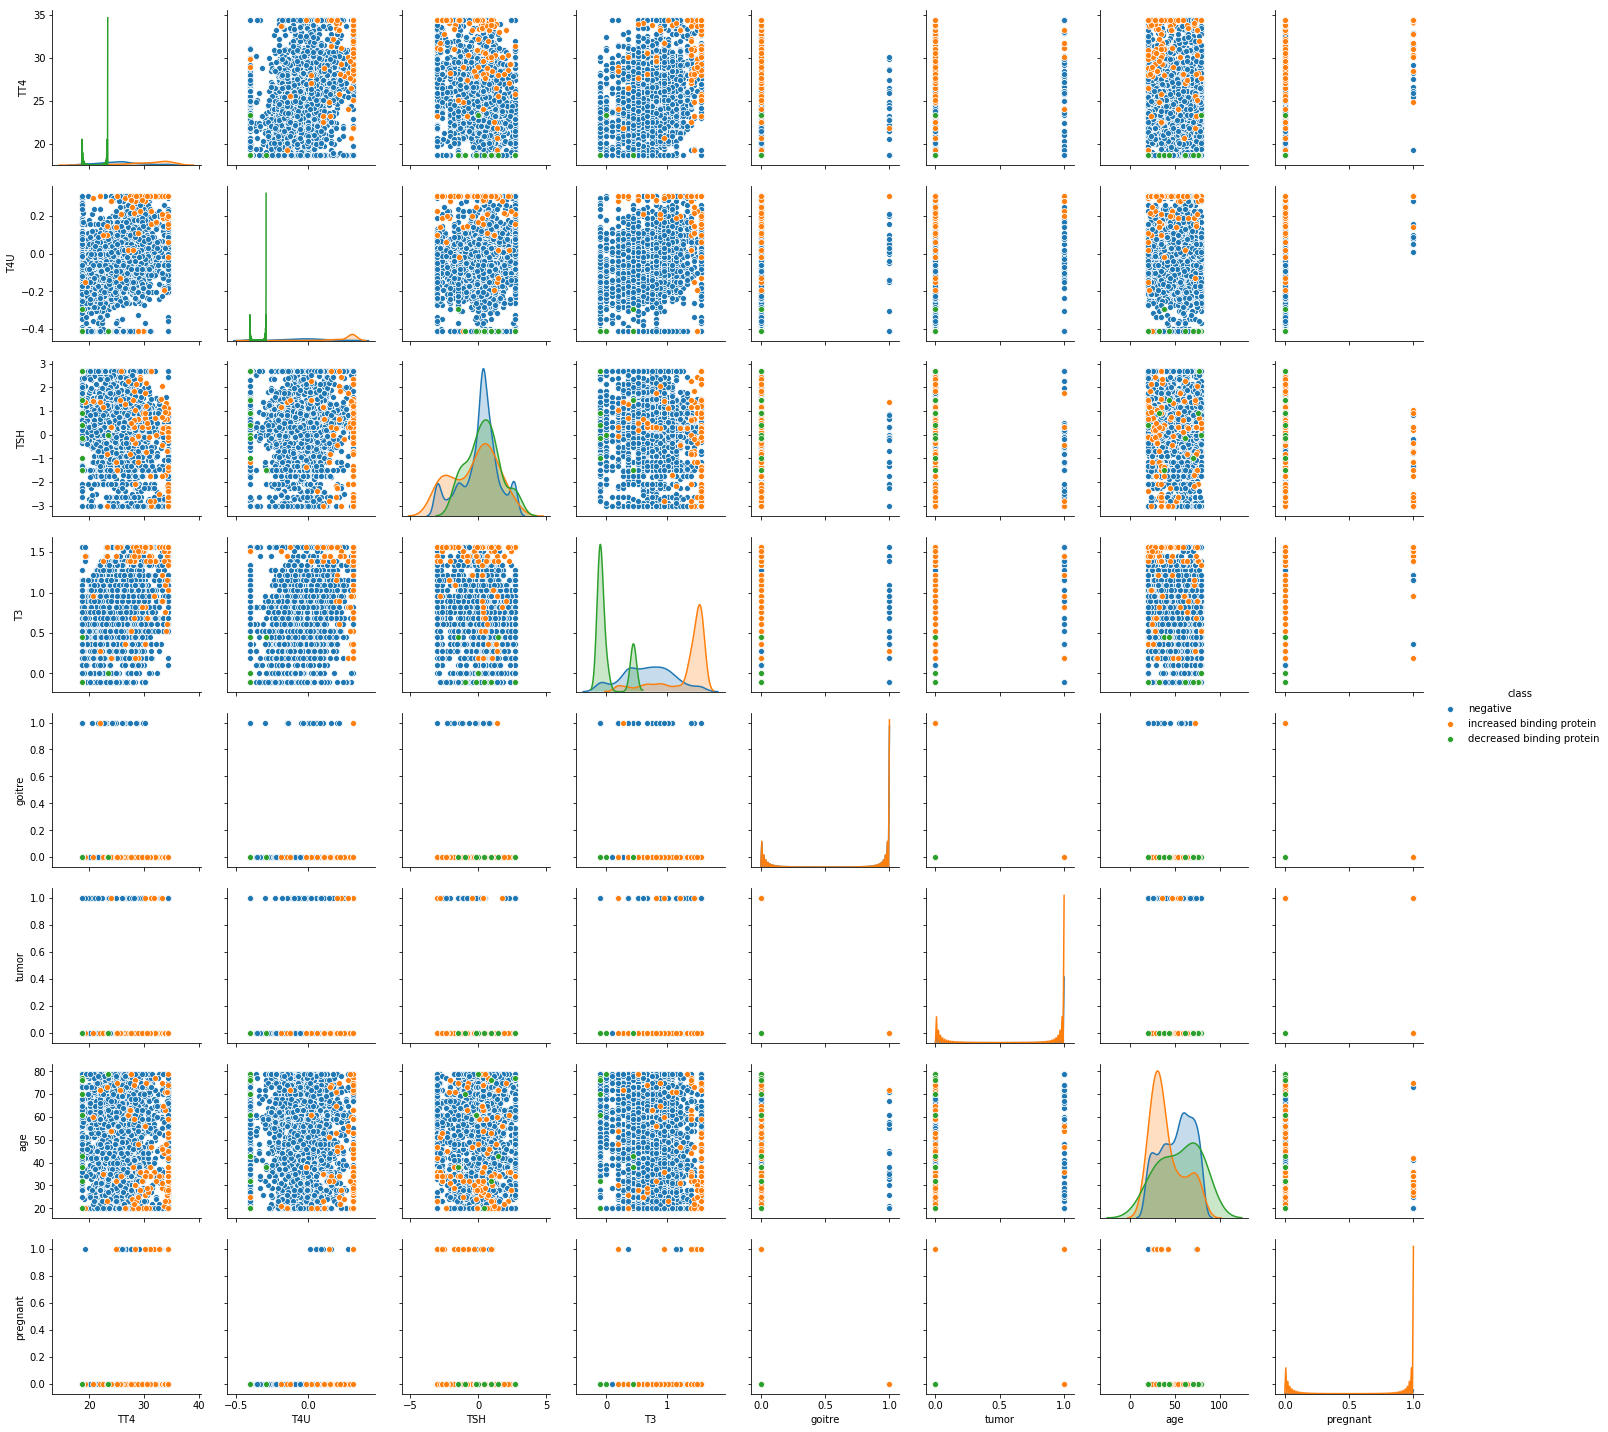

In [19]:
sns.pairplot(data_train[data_train['class'] != 'nan'], hue='class', vars=['TT4', 'T4U', 'TSH', 'T3', 'goitre', 'tumor', 'age', 'pregnant'])

In [65]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [21]:
def printDistribution(attribute):
    sns.distplot(data_train[data_train['class'] == 'negative'][attribute].dropna())
    sns.distplot(data_train[data_train['class'] == 'increased binding protein'][attribute].dropna())
    sns.distplot(data_train[data_train['class'] == 'decreased binding protein'][attribute].dropna())
    plt.show()    

In [59]:
def test(name, df):
    print(" ********************** Results *************************** ")
    print("Alghoritm used= ")
    print(name)
    print(" ")

    #output = predicted[:, i].reshape(-1, 1)

    print("Accuracy Score= ")
    print(accuracy_score(df['class'], df['class_predicted']))
    print(" ")

    print("Confusion Matrix= ")
    print(confusion_matrix(df['class'], df['class_predicted']))
    print(" ")

    print("Precision/Recall/F1 Score=")
    print(classification_report(df['class'], df['class_predicted']))
    print(" ")

    print("Area Under Curve=")
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(df['class'], df['class_predicted'])
    #roc_auc = auc(false_positive_rate, true_positive_rate)
    #print(roc_auc)

    print(" **********************************************************")

### Pravidlo 1: Ked je T3 vacsi ako 1.5, tak ma increased binding protein

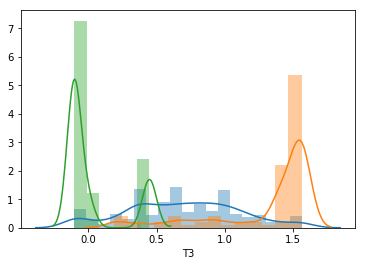

In [23]:
printDistribution('T3')

In [24]:
data_train[data_train['T3'] > 1.4].groupby(['class']).count()

Unnamed: 0_x  name  address  age  sex  \
class                                                              
increased binding protein            60    60       60   60   60   
negative                             90    90       90   90   90   

                           date_of_birth  FTI measured  I131 treatment  T3  \
class                                                                        
increased binding protein             60            60              60  60   
negative                              90            90              90  90   

                           T3 measured  T4U  TSH  TT4  Unnamed: 0_y  \
class                                                                 
increased binding protein           60   60   60   60            60   
negative                            90   90   90   90            90   

                           capital-gain  capital-loss  education  \
class                                                              
increased binding protein            60            60         60   
negative                             90            90         90   

                           education-num  fnlwgt  goitre  hours-per-week  \
class                                                                      
increased binding protein             55      60      60              60   
negative                              81      90      90              90   

                           lithium  marital-status  native-country  \
class                                                                
increased binding protein       60              60              60   
negative                        90              90              90   

                           occupation  on thyroxine  pregnant  \
class                                                           
increased binding protein          60            60        60   
negative                           90            90        90   

                           query on thyroxine  race  referral source  \
class                                                                  
increased binding protein                  60    60               60   
negative                                   90    90               90   

                           relationship  thyroid surgery  tumor  workclass  \
class                                                                        
increased binding protein            60               60     60         54   
negative                             90               90     90         84   

                           TSH measured  query hyperthyroid  TT4 measured  \
class                                                                       
increased binding protein            60                  60            60   
negative                             90                  90            90   

                           on antithyroid medication  FTI  sick  T4U measured  \
class                                                                           
increased binding protein                         60   60    60            60   
negative                                          90   90    90            90   

                           psych  query hypothyroid  cur_year  \
class                                                           
increased binding protein     60                 60        60   
negative                      90                 90        90   

                           measured_hormones  
class                                         
increased binding protein                 60  
negative                                  90

In [25]:
data_valid['class_predicted'] = data_valid.apply(lambda x: 'increased binding protein' if x['T3'] > 1.4 else 'negative', axis=1)
test('T3', data_valid)

 ********************** Results *************************** 
Alghoritm used= 
T3
 
Accuracy Score= 
0.9526151095216808
 
Confusion Matrix= 
[[   0    0    9]
 [   0    0   97]
 [   0    0 2131]]
 
Precision/Recall/F1 Score=
                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         9
increased binding protein       0.00      0.00      0.00        97
                 negative       0.95      1.00      0.98      2131

                micro avg       0.95      0.95      0.95      2237
                macro avg       0.32      0.33      0.33      2237
             weighted avg       0.91      0.95      0.93      2237

 
Area Under Curve=
 **********************************************************


/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
data_valid[data_valid['class_predicted'] != 'negative']

Empty DataFrame
Columns: [Unnamed: 0_x, name, address, age, sex, date_of_birth, FTI measured, I131 treatment, T3, T3 measured, T4U, TSH, TT4, Unnamed: 0_y, capital-gain, capital-loss, class, education, education-num, fnlwgt, goitre, hours-per-week, lithium, marital-status, native-country, occupation, on thyroxine, pregnant, query on thyroxine, race, referral source, relationship, thyroid surgery, tumor, workclass, TSH measured, query hyperthyroid, TT4 measured, on antithyroid medication, FTI, sick, T4U measured, psych, query hypothyroid, cur_year, measured_hormones, class_predicted]
Index: []

### Pravidlo 2: Ked je T4U vacsi ako 0.25, tak ma increased binding protein

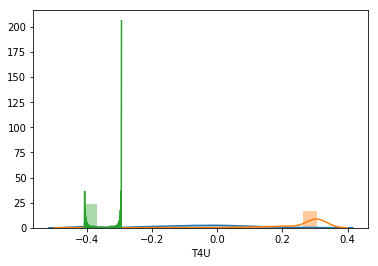

In [27]:
printDistribution('T4U')

In [28]:
data_train[data_train['T4U'] > 0.25].groupby(['class']).count()

Unnamed: 0_x  name  address  age  sex  \
class                                                              
increased binding protein            67    67       67   67   67   
negative                             74    74       74   74   74   

                           date_of_birth  FTI measured  I131 treatment  T3  \
class                                                                        
increased binding protein             67            67              67  67   
negative                              74            74              74  74   

                           T3 measured  T4U  TSH  TT4  Unnamed: 0_y  \
class                                                                 
increased binding protein           67   67   67   67            67   
negative                            74   74   74   74            74   

                           capital-gain  capital-loss  education  \
class                                                              
increased binding protein            67            67         67   
negative                             74            74         74   

                           education-num  fnlwgt  goitre  hours-per-week  \
class                                                                      
increased binding protein             63      67      67              67   
negative                              70      74      74              74   

                           lithium  marital-status  native-country  \
class                                                                
increased binding protein       67              67              67   
negative                        74              74              74   

                           occupation  on thyroxine  pregnant  \
class                                                           
increased binding protein          67            67        67   
negative                           74            74        74   

                           query on thyroxine  race  referral source  \
class                                                                  
increased binding protein                  67    67               67   
negative                                   74    74               74   

                           relationship  thyroid surgery  tumor  workclass  \
class                                                                        
increased binding protein            67               67     67         60   
negative                             74               74     74         69   

                           TSH measured  query hyperthyroid  TT4 measured  \
class                                                                       
increased binding protein            67                  67            67   
negative                             74                  74            74   

                           on antithyroid medication  FTI  sick  T4U measured  \
class                                                                           
increased binding protein                         67   67    67            67   
negative                                          74   74    74            74   

                           psych  query hypothyroid  cur_year  \
class                                                           
increased binding protein     67                 67        67   
negative                      74                 74        74   

                           measured_hormones  
class                                         
increased binding protein                 67  
negative                                  74

In [29]:
data_valid['class_predicted'] = data_valid['T4U'].apply(lambda x: 'increased binding protein' if x > 0.25 else 'negative')
test('T4U', data_valid)

 ********************** Results *************************** 
Alghoritm used= 
T4U
 
Accuracy Score= 
0.9526151095216808
 
Confusion Matrix= 
[[   0    0    9]
 [   0    0   97]
 [   0    0 2131]]
 
Precision/Recall/F1 Score=
                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         9
increased binding protein       0.00      0.00      0.00        97
                 negative       0.95      1.00      0.98      2131

                micro avg       0.95      0.95      0.95      2237
                macro avg       0.32      0.33      0.33      2237
             weighted avg       0.91      0.95      0.93      2237

 
Area Under Curve=
 **********************************************************


/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Pravidlo 3: Ked je zena po 25 tehotna, tak ma increased binding protein

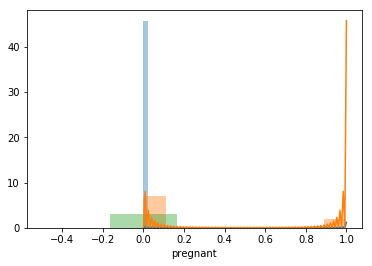

In [30]:
printDistribution('pregnant')

In [31]:
data_train[(data_train['pregnant'] > 0.85) & (data_train['age'] > 25)].groupby(['class']).count()

Unnamed: 0_x  name  address  age  sex  \
class                                                              
increased binding protein            21    21       21   21   21   
negative                              9     9        9    9    9   

                           date_of_birth  FTI measured  I131 treatment  T3  \
class                                                                        
increased binding protein             21            21              21  21   
negative                               9             9               9   9   

                           T3 measured  T4U  TSH  TT4  Unnamed: 0_y  \
class                                                                 
increased binding protein           21   21   21   21            21   
negative                             9    9    9    9             9   

                           capital-gain  capital-loss  education  \
class                                                              
increased binding protein            21            21         21   
negative                              9             9          9   

                           education-num  fnlwgt  goitre  hours-per-week  \
class                                                                      
increased binding protein             20      21      21              21   
negative                               8       9       9               9   

                           lithium  marital-status  native-country  \
class                                                                
increased binding protein       21              21              21   
negative                         9               9               9   

                           occupation  on thyroxine  pregnant  \
class                                                           
increased binding protein          21            21        21   
negative                            9             9         9   

                           query on thyroxine  race  referral source  \
class                                                                  
increased binding protein                  21    21               21   
negative                                    9     9                9   

                           relationship  thyroid surgery  tumor  workclass  \
class                                                                        
increased binding protein            21               21     21         18   
negative                              9                9      9          8   

                           TSH measured  query hyperthyroid  TT4 measured  \
class                                                                       
increased binding protein            21                  21            21   
negative                              9                   9             9   

                           on antithyroid medication  FTI  sick  T4U measured  \
class                                                                           
increased binding protein                         21   21    21            21   
negative                                           9    9     9             9   

                           psych  query hypothyroid  cur_year  \
class                                                           
increased binding protein     21                 21        21   
negative                       9                  9         9   

                           measured_hormones  
class                                         
increased binding protein                 21  
negative                                   9

In [32]:
def ruleAgePregnant(row):
    if row['pregnant'] > 0.85 and row['age'] > 25:
        return 'increased binding protein'
    return 'negative'
data_valid['class_predicted'] = data_valid.apply(lambda x: ruleAgePregnant(x), axis=1)
test('pregnant', data_valid)

 ********************** Results *************************** 
Alghoritm used= 
pregnant
 
Accuracy Score= 
0.9579794367456415
 
Confusion Matrix= 
[[   0    0    9]
 [   0   21   76]
 [   0    9 2122]]
 
Precision/Recall/F1 Score=
                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         9
increased binding protein       0.70      0.22      0.33        97
                 negative       0.96      1.00      0.98      2131

                micro avg       0.96      0.96      0.96      2237
                macro avg       0.55      0.40      0.44      2237
             weighted avg       0.95      0.96      0.95      2237

 
Area Under Curve=
 **********************************************************


/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


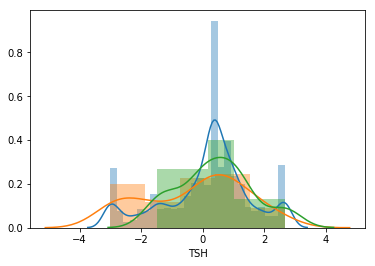

In [33]:
printDistribution('TSH')

In [34]:
data_train[(data_train['TSH'] < 0) & (data_train['age'] < 40)].groupby(['class']).count()

Unnamed: 0_x  name  address  age  sex  \
class                                                              
decreased binding protein             1     1        1    1    1   
increased binding protein            30    30       30   30   30   
negative                            186   186      186  186  186   

                           date_of_birth  FTI measured  I131 treatment   T3  \
class                                                                         
decreased binding protein              1             1               1    1   
increased binding protein             30            30              30   30   
negative                             186           186             186  186   

                           T3 measured  T4U  TSH  TT4  Unnamed: 0_y  \
class                                                                 
decreased binding protein            1    1    1    1             1   
increased binding protein           30   30   30   30            30   
negative                           186  186  186  186           186   

                           capital-gain  capital-loss  education  \
class                                                              
decreased binding protein             1             1          1   
increased binding protein            30            30         30   
negative                            186           186        186   

                           education-num  fnlwgt  goitre  hours-per-week  \
class                                                                      
decreased binding protein              1       1       1               1   
increased binding protein             27      30      30              30   
negative                             170     186     186             186   

                           lithium  marital-status  native-country  \
class                                                                
decreased binding protein        1               1               1   
increased binding protein       30              30              30   
negative                       186             186             186   

                           occupation  on thyroxine  pregnant  \
class                                                           
decreased binding protein           1             1         1   
increased binding protein          30            30        30   
negative                          186           186       186   

                           query on thyroxine  race  referral source  \
class                                                                  
decreased binding protein                   1     1                1   
increased binding protein                  30    30               30   
negative                                  186   186              186   

                           relationship  thyroid surgery  tumor  workclass  \
class                                                                        
decreased binding protein             1                1      1          1   
increased binding protein            30               30     30         26   
negative                            186              186    186        176   

                           TSH measured  query hyperthyroid  TT4 measured  \
class                                                                       
decreased binding protein             1                   1             1   
increased binding protein            30                  30            30   
negative                            186                 186           186   

                           on antithyroid medication  FTI  sick  T4U measured  \
class                                                                           
decreased binding protein                          1    1     1             1   
increased binding protein                         30   30    30            30   
negative                                         186  186   186          

----

In [63]:
def score(name, predicted, valid):
    print(" ********************** Results *************************** ")
    print("Alghoritm used= ")
    print(name)
    print(" ")

    #output = predicted[:, i].reshape(-1, 1)

    print("Accuracy Score= ")
    print(accuracy_score(valid, predicted))
    print(" ")

    print("Confusion Matrix= ")
    print(confusion_matrix(valid, predicted))
    print(" ")

    print("Precision/Recall/F1 Score=")
    print(classification_report(valid, predicted))
    print(" ")

    print(" **********************************************************")

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [120]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

In [159]:
# Rozdelenie trenovacich dat pre natrenovanie klasifikatoru
X_train = data_train.drop(['class'], axis=1)
Y_train = le.fit_transform(data_train[['class']])

# Rozdelenie validacnych dat
X_valid = data_valid.drop(['class'], axis=1)
Y_valid = le.fit_transform(data_valid[['class']])

/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [160]:
ss = pd.DataFrame(Y_valid)
ss[0].value_counts()

2    2131
1      97
0       9
Name: 0, dtype: int64

In [161]:
data_valid['class'].value_counts()

negative                     2131
increased binding protein      97
decreased binding protein       9
Name: class, dtype: int64

In [162]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights

array([82.85185185,  7.68728522,  0.34991397])

In [181]:
clf = DecisionTreeClassifier(class_weight={2:0.35, 1:7.68, 0:82.51})
clf.fit(X_train, Y_train)
predictions = clf.predict(X_valid)

In [182]:
score("CART", Y_valid, predictions)

 ********************** Results *************************** 
Alghoritm used= 
CART
 
Accuracy Score= 
0.8167188198480108
 
Confusion Matrix= 
[[   9    9  313]
 [   0    0    0]
 [   0   88 1818]]
 
Precision/Recall/F1 Score=
              precision    recall  f1-score   support

           0       1.00      0.03      0.05       331
           1       0.00      0.00      0.00         0
           2       0.85      0.95      0.90      1906

   micro avg       0.82      0.82      0.82      2237
   macro avg       0.62      0.33      0.32      2237
weighted avg       0.87      0.82      0.78      2237

 
 **********************************************************


/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [128]:
from sklearn.linear_model import LogisticRegression

In [179]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, Y_train)

predictions = lr.predict(X_valid)

/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [180]:
score("Logistic Regression", Y_valid, predictions)

 ********************** Results *************************** 
Alghoritm used= 
Logistic Regression
 
Accuracy Score= 
0.9526151095216808
 
Confusion Matrix= 
[[   0    0    0]
 [   0    0    0]
 [   9   97 2131]]
 
Precision/Recall/F1 Score=
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.95      0.98      2237

   micro avg       0.95      0.95      0.95      2237
   macro avg       0.33      0.32      0.33      2237
weighted avg       1.00      0.95      0.98      2237

 
 **********************************************************


/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


- Age
- One hot encoding